In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import yaml
from yaml import Loader
import numpy as np
import analyze_cells_energy as ace
import utils
from scipy.stats import ttest_ind, mannwhitneyu
import networkx as nx
import copy
import itertools
from utils_graphs import select_significant_areas, create_graph, plot_graph, get_colors
import utils_PLS as upls
import matplotlib.colors as cm
from matplotlib.lines import Line2D

In [2]:
# load query file where we added volumes for each area
volumes = pd.read_csv("query_volumes_reordered.csv")
volumes = ace.clean_volumes_database(volumes)

In [3]:
root_directory = '/home/stella/Documents/Torino/projects/'
experiment = 'SexualImprinting'
experimental_group = 'SWISS_MaleUrine_Exposure'
data_directory = root_directory + experiment + '/' \
                + experimental_group + '/'
dict_results_across_mice = np.load('dict_results/dict_results_across_mice_SW19-35-200_10-10.npy', allow_pickle=True).item()
subjects = list(dict_results_across_mice.keys())
experimental_groups = utils.divide_in_exp_groups(list_subjects=subjects)
df_control_cell_count, df_fam_cell_count, df_unfam_cell_count = \
ace.calculate_value_across_groups(experimental_groups=experimental_groups, 
                              dict_results_across_mice=dict_results_across_mice, 
                              value='n_cells')
df_ttest_ncells = ace.test_across_groups(df_control=df_control_cell_count, 
                               df_fam=df_fam_cell_count, 
                               df_unfam=df_unfam_cell_count)
df_ttest_not_null_ncells = df_ttest_ncells.dropna(axis=0,
                                   how='all',
                                   subset=['pval_Control_vs_Fam',
                                          'pval_Control_vs_Unfam',
                                          'pval_Fam_vs_Unfam'])
df_mannwhitneyu_ncells = ace.test_across_groups(df_control=df_control_cell_count, 
                               df_fam=df_fam_cell_count, 
                               df_unfam=df_unfam_cell_count,
                                           test='mannwhitneyu')
df_mannwhitneyu_not_null_ncells = df_mannwhitneyu_ncells.dropna(axis=0,
                                   how='all',
                                   subset=['pval_Control_vs_Fam',
                                          'pval_Control_vs_Unfam',
                                          'pval_Fam_vs_Unfam'])
sig_areas_ncells_ttest = select_significant_areas(df=df_ttest_not_null_ncells, threshold=0.05)
sig_areas_ncells_mannwhitneyu = select_significant_areas(df=df_mannwhitneyu_not_null_ncells, threshold=0.05)
corr_matrix_control_ncells = ace.cross_corr(df_control_cell_count)
corr_matrix_fam_ncells = ace.cross_corr(df_fam_cell_count)
corr_matrix_unfam_ncells = ace.cross_corr(df_unfam_cell_count)

In [4]:
corr_threshold = 0.75
allen_order = list(volumes[volumes['st_level']==8]['acronym'])

In [5]:
G_control = create_graph(corr_matrix_control_ncells, volumes=volumes, 
                         significant_areas=sig_areas_ncells_ttest, 
                         corr_threshold=corr_threshold, correlations='one')
G_fam = create_graph(corr_matrix_fam_ncells,  volumes=volumes, 
                         significant_areas=sig_areas_ncells_ttest, 
                         corr_threshold=corr_threshold, correlations='one')
G_unfam = create_graph(corr_matrix_unfam_ncells,  volumes=volumes, 
                         significant_areas=sig_areas_ncells_ttest, 
                         corr_threshold=corr_threshold, correlations='one')

/home/stella/Documents/Torino/projects/ClearMap2/ClearMap/Scripts/utils_graphs.py:32: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if significant_areas!=0:
/home/stella/Documents/Torino/projects/ClearMap2/ClearMap/Scripts/utils_graphs.py:32: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if significant_areas!=0:
/home/stella/Documents/Torino/projects/ClearMap2/ClearMap/Scripts/utils_graphs.py:32: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if significant_areas!=0:


In [6]:
corr_threshold > 0

True

In [7]:
df_levels = upls.create_df_levels(volumes)

# TODOs: 
1) grandezza nodi per fold change

2) PLS girandola due volte sulle aree selezionate dalla prima PLS

3) Grafi da aree PLS

4) Grafi con le aree anticorrelate (X)

5) Correlazione e grafi con energia da confrontare con grafi n cellule


# Graphs of positive correlations

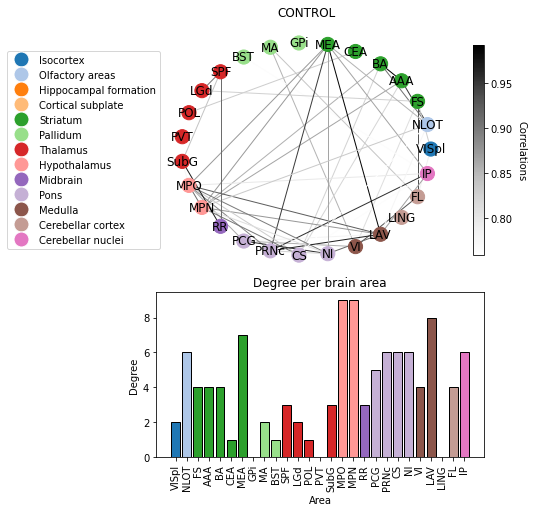

In [8]:
fig = plt.figure("control", figsize=(7, 8))
plt.subplots_adjust(left=0.25)

edge_cmap = plt.cm.get_cmap('Greys')

# Create a gridspec for adding subplots of different sizes
axgrid = fig.add_gridspec(5, 4)
# plot graph
ax0 = fig.add_subplot(axgrid[0:3, :])
plot_graph(G=G_control,order=allen_order, df_levels=df_levels, volumes=volumes, ax=ax0, title='CONTROL',
          edge_cmap=edge_cmap)

colors_dict = get_colors(G_control, df_levels=df_levels, order=allen_order, volumes=volumes)[1]
areas = sorted(list(G_control.nodes()), key = allen_order.index)
degrees = [G_control.degree()[area] for area in areas]
# plot degrees
ax1 = fig.add_subplot(axgrid[3:, :])
ax1.bar(x= areas, 
        height= degrees)

for idx, color in enumerate(get_colors(G_control, 
                                       df_levels=df_levels, 
                                       order=allen_order,
                                       sorting=True, volumes=volumes)[0]):
    ax1.get_children()[idx].set_color(color) 
    ax1.get_children()[idx].set_edgecolor('black')
    
ax1.set_title("Degree per brain area")
ax1.set_ylabel("Degree")
ax1.set_xlabel("Area")
ax1.tick_params(axis='x', labelrotation=90)

legend_elements = [Line2D([0], [0], marker='o', color='w', label=area,
                          markerfacecolor=colors_dict[area], markersize=15) \
                   for area in colors_dict.keys()]

# Create the figure
ax0.legend(handles=legend_elements, loc='right', bbox_to_anchor=(0.03,0.5))

# colorbar
weights = [G_control[u][v]['weight'] for u, v in G_control.edges]
color_weights=np.array(weights)
cmap=edge_cmap
vmin=min(weights)
vmax=max(weights)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
# sm._A = []
cbar = plt.colorbar(sm, ax=ax0,fraction=0.032)
cbar.set_label('Correlations', rotation=270, labelpad=13)

plt.savefig('/home/stella/Documents/Torino/projects/SexualImprinting/figures/graph_control_SWISS_200_10-10.svg')
plt.savefig('/home/stella/Documents/Torino/projects/SexualImprinting/figures/graph_control_SWISS_200_10-10.png')

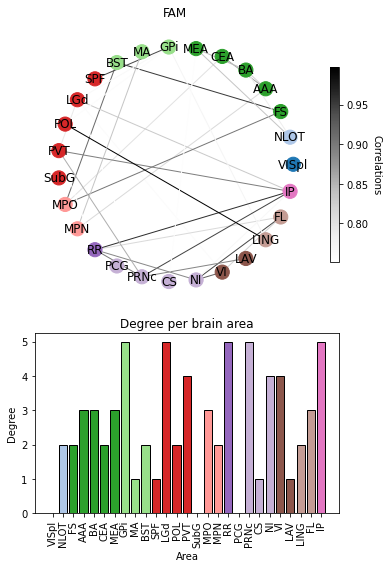

In [10]:
fig = plt.figure("fam", figsize=(5.5, 8))
# Create a gridspec for adding subplots of different sizes
axgrid = fig.add_gridspec(5, 4)

edge_cmap = plt.cm.get_cmap('Greys')

ax0 = fig.add_subplot(axgrid[0:3, :])
plot_graph(G=G_fam,order=allen_order, df_levels=df_levels, volumes=volumes, ax=ax0, title='FAM',
          edge_cmap=edge_cmap)

areas = sorted(list(G_fam.nodes()), key = allen_order.index)
degrees = [G_fam.degree()[area] for area in areas]
ax1 = fig.add_subplot(axgrid[3:, :])
ax1.bar(x= areas, 
        height= degrees,
       color='steelblue')

for idx, color in enumerate(get_colors(G_fam, 
                                       df_levels=df_levels, 
                                       order=allen_order,
                                       sorting=True, volumes=volumes)[0]):
    ax1.get_children()[idx].set_color(color) 
    ax1.get_children()[idx].set_edgecolor('black')
    
ax1.set_title("Degree per brain area")
ax1.set_ylabel("Degree")
ax1.set_xlabel("Area")
ax1.tick_params(axis='x', labelrotation=90)

# colorbar
weights = [G_fam[u][v]['weight'] for u, v in G_fam.edges]
color_weights=np.array(weights)
cmap=edge_cmap
vmin=min(weights)
vmax=max(weights)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
# sm._A = []
cbar = plt.colorbar(sm, ax=ax0,fraction=0.032)
cbar.set_label('Correlations', rotation=270, labelpad=13)

fig.tight_layout()
plt.savefig('/home/stella/Documents/Torino/projects/SexualImprinting/figures/graph_fam_SWISS_200_10-10.svg')
plt.savefig('/home/stella/Documents/Torino/projects/SexualImprinting/figures/graph_fam_SWISS_200_10-10.png')

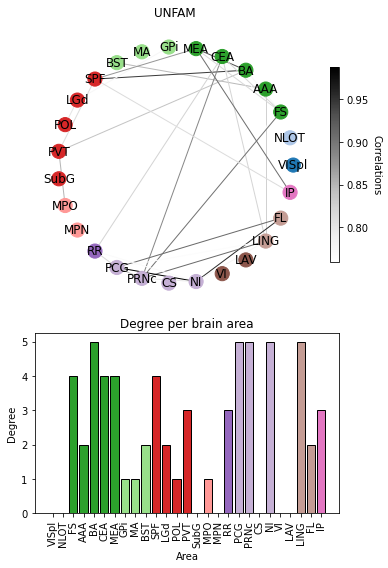

In [11]:
fig = plt.figure("unfam", figsize=(5.5, 8))
# Create a gridspec for adding subplots of different sizes
axgrid = fig.add_gridspec(5, 4)

edge_cmap = plt.cm.get_cmap('Greys')

ax0 = fig.add_subplot(axgrid[0:3, :])
plot_graph(G=G_unfam,order=allen_order, df_levels=df_levels, volumes=volumes, ax=ax0, title='UNFAM',
          edge_cmap=edge_cmap)

areas = sorted(list(G_unfam.nodes()), key = allen_order.index)
degrees = [G_unfam.degree()[area] for area in areas]
ax1 = fig.add_subplot(axgrid[3:, :])
ax1.bar(x= areas, 
        height= degrees,
       color='steelblue')

for idx, color in enumerate(get_colors(G_unfam, 
                                       df_levels=df_levels, 
                                       order=allen_order,
                                       sorting=True, volumes=volumes)[0]):
    ax1.get_children()[idx].set_color(color) 
    ax1.get_children()[idx].set_edgecolor('black')
    
ax1.set_title("Degree per brain area")
ax1.set_ylabel("Degree")
ax1.set_xlabel("Area")
ax1.tick_params(axis='x', labelrotation=90)

# colorbar
weights = [G_unfam[u][v]['weight'] for u, v in G_unfam.edges]
color_weights=np.array(weights)
cmap=edge_cmap
vmin=min(weights)
vmax=max(weights)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
# sm._A = []
cbar = plt.colorbar(sm, ax=ax0,fraction=0.032)
cbar.set_label('Correlations', rotation=270, labelpad=13)

fig.tight_layout()
plt.savefig('/home/stella/Documents/Torino/projects/SexualImprinting/figures/graph_unfam_SWISS_200_10-10.svg')
plt.savefig('/home/stella/Documents/Torino/projects/SexualImprinting/figures/graph_unfam_SWISS_200_10-10.png')

## Histogram degrees

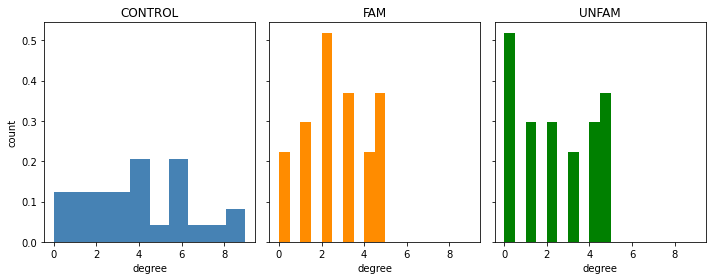

In [12]:
fig, axes = plt.subplots(1,3, figsize=(10,4), sharex=True, sharey=True)
axes[0].set_title('CONTROL')
axes[0].hist(list(dict(G_control.degree).values()),
            color='steelblue', density=True)
axes[1].set_title('FAM')
axes[1].hist(list(dict(G_fam.degree).values()),
            color='darkorange', density=True)
axes[2].set_title('UNFAM')
axes[2].hist(list(dict(G_unfam.degree).values()),
            color='green', density=True)
for i in range(3):
    axes[i].set_xlabel('degree')
axes[0].set_ylabel('count')
plt.tight_layout()
plt.savefig('/home/stella/Documents/Torino/projects/SexualImprinting/figures/hist_degree_SWISS_200_10-10.svg')
plt.savefig('/home/stella/Documents/Torino/projects/SexualImprinting/figures/hist_degree_SWISS_200_10-10.png')

Text(0, 0.5, 'Degree')

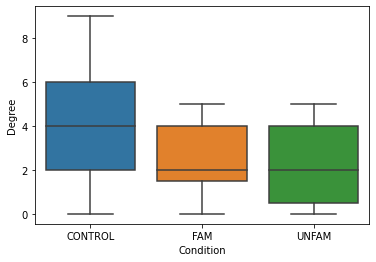

In [13]:
df_boxplot = pd.DataFrame({'CONTROL':list(dict(G_control.degree).values()), 
                           'FAM': list(dict(G_fam.degree).values()), 
                           'UNFAM':list(dict(G_unfam.degree).values())})
fig, ax = plt.subplots(1,1)
sns.boxplot(data=df_boxplot, ax=ax)
ax.set_xlabel('Condition')
ax.set_ylabel('Degree')

## Histogram weights

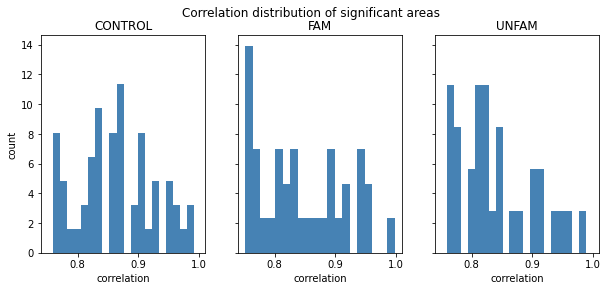

In [14]:
fig, axes = plt.subplots(1,3, figsize=(10,4), sharex=True, sharey=True)
for i, G in enumerate([G_control, G_fam, G_unfam]):
    axes[i].hist([G[u][v]['weight'] for u, v in G.edges],
            color='steelblue', bins=20, density=True)
axes[0].set_title('CONTROL')
axes[1].set_title('FAM')
axes[2].set_title('UNFAM')
for i in range(3):
    axes[i].set_xlabel('correlation')
axes[0].set_ylabel('count')
plt.suptitle('Correlation distribution of significant areas')
plt.savefig('/home/stella/Documents/Torino/projects/SexualImprinting/figures/hist_correlation_SWISS_200_10-10.svg')
plt.savefig('/home/stella/Documents/Torino/projects/SexualImprinting/figures/hist_correlation_SWISS_200_10-10.png')

# Overall correlations

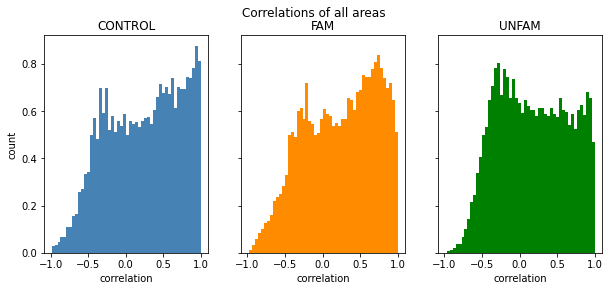

In [15]:
fig, axes = plt.subplots(1,3, figsize=(10,4), sharex=True, sharey=True)
colors = ['steelblue', 'darkorange', 'green']
for i, corr in enumerate([corr_matrix_control_ncells, 
                          corr_matrix_fam_ncells, 
                          corr_matrix_unfam_ncells]):
    axes[i].hist(corr.mask(np.triu(np.ones(corr.shape)).astype(bool)).stack().values,
            color=colors[i], bins=50, density=True)
axes[0].set_title('CONTROL')
axes[1].set_title('FAM')
axes[2].set_title('UNFAM')
for i in range(3):
    axes[i].set_xlabel('correlation')
axes[0].set_ylabel('count')
plt.suptitle('Correlations of all areas')
plt.savefig('/home/stella/Documents/Torino/projects/SexualImprinting/figures/hist_correlation_all_SWISS_200_10-10.svg')
plt.savefig('/home/stella/Documents/Torino/projects/SexualImprinting/figures/hist_correlation_all_SWISS_200_10-10.png')

# Positive and negative correlations

In [16]:
G_control = create_graph(corr_matrix_control_ncells, volumes=volumes, 
                         significant_areas=sig_areas_ncells_ttest, 
                         corr_threshold=corr_threshold, correlations='both')
G_fam = create_graph(corr_matrix_fam_ncells,  volumes=volumes, 
                         significant_areas=sig_areas_ncells_ttest, 
                         corr_threshold=corr_threshold, correlations='both')
G_unfam = create_graph(corr_matrix_unfam_ncells,  volumes=volumes, 
                         significant_areas=sig_areas_ncells_ttest, 
                         corr_threshold=corr_threshold, correlations='both')

/home/stella/Documents/Torino/projects/ClearMap2/ClearMap/Scripts/utils_graphs.py:32: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if significant_areas!=0:
/home/stella/Documents/Torino/projects/ClearMap2/ClearMap/Scripts/utils_graphs.py:32: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if significant_areas!=0:
/home/stella/Documents/Torino/projects/ClearMap2/ClearMap/Scripts/utils_graphs.py:32: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if significant_areas!=0:


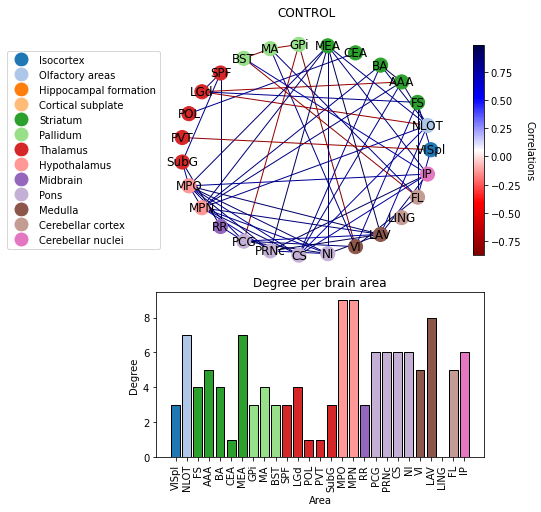

In [18]:
fig = plt.figure("control", figsize=(7, 8))
plt.subplots_adjust(left=0.25)
# Create a gridspec for adding subplots of different sizes
axgrid = fig.add_gridspec(5, 4)
edge_cmap = plt.cm.get_cmap('seismic_r')
# plot graph
ax0 = fig.add_subplot(axgrid[0:3, :])

plot_graph(G=G_control,order=allen_order, df_levels=df_levels, volumes=volumes, ax=ax0, title='CONTROL',
          edge_cmap = plt.cm.get_cmap('seismic_r'))

colors_dict = get_colors(G_control, df_levels=df_levels, order=allen_order, volumes=volumes)[1]
areas = sorted(list(G_control.nodes()), key = allen_order.index)
degrees = [G_control.degree()[area] for area in areas]
# plot degrees
ax1 = fig.add_subplot(axgrid[3:, :])
ax1.bar(x= areas, 
        height= degrees)

for idx, color in enumerate(get_colors(G_control, 
                                       df_levels=df_levels, 
                                       order=allen_order,
                                       sorting=True, volumes=volumes)[0]):
    ax1.get_children()[idx].set_color(color) 
    ax1.get_children()[idx].set_edgecolor('black')
    
ax1.set_title("Degree per brain area")
ax1.set_ylabel("Degree")
ax1.set_xlabel("Area")
ax1.tick_params(axis='x', labelrotation=90)

legend_elements = [Line2D([0], [0], marker='o', color='w', label=area,
                          markerfacecolor=colors_dict[area], markersize=15) \
                   for area in colors_dict.keys()]

# Create the legend
ax0.legend(handles=legend_elements, loc='right', bbox_to_anchor=(0.03,0.5))

# colorbar
weights = [G_control[u][v]['weight'] for u, v in G_control.edges]
color_weights=np.array(weights)
cmap=edge_cmap
vmin = min(weights)
vmax = max(weights)
sm = plt.cm.ScalarMappable(cmap=edge_cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
cbar = plt.colorbar(sm, ax=ax0,fraction=0.032)
cbar.set_label('Correlations', rotation=270, labelpad=13)

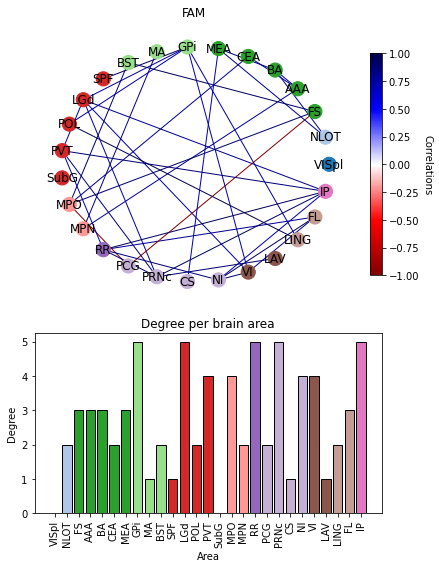

In [19]:
fig = plt.figure("fam", figsize=(5.5, 8))
# Create a gridspec for adding subplots of different sizes
axgrid = fig.add_gridspec(5, 4)
edge_cmap = plt.cm.get_cmap('seismic_r')

ax0 = fig.add_subplot(axgrid[0:3, :])
plot_graph(G=G_fam,order=allen_order, df_levels=df_levels, volumes=volumes, ax=ax0, title='FAM',
          edge_cmap = edge_cmap)

areas = sorted(list(G_fam.nodes()), key = allen_order.index)
degrees = [G_fam.degree()[area] for area in areas]
ax1 = fig.add_subplot(axgrid[3:, :])
ax1.bar(x= areas, 
        height= degrees,
       color='steelblue')

for idx, color in enumerate(get_colors(G_fam, 
                                       df_levels=df_levels, 
                                       order=allen_order,
                                       sorting=True, volumes=volumes)[0]):
    ax1.get_children()[idx].set_color(color) 
    ax1.get_children()[idx].set_edgecolor('black')
    
ax1.set_title("Degree per brain area")
ax1.set_ylabel("Degree")
ax1.set_xlabel("Area")
ax1.tick_params(axis='x', labelrotation=90)

fig.tight_layout()
# colorbar
weights = [G_fam[u][v]['weight'] for u, v in G_fam.edges]
color_weights=np.array(weights)
cmap=edge_cmap
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = -1, vmax=1))
# sm._A = []
cbar = plt.colorbar(sm, ax=ax0,fraction=0.032)
cbar.set_label('Correlations', rotation=270, labelpad=13)

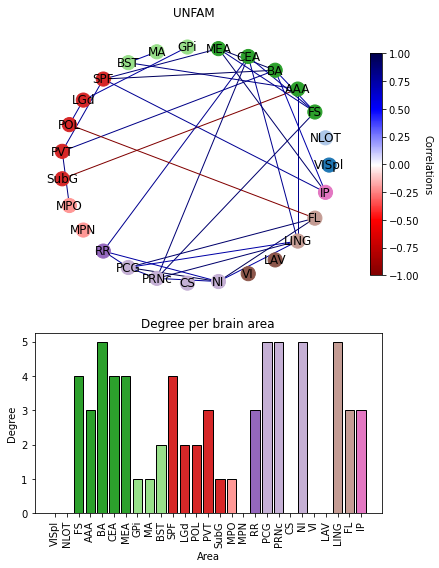

In [20]:
fig = plt.figure("unfam", figsize=(5.5, 8))
# Create a gridspec for adding subplots of different sizes
axgrid = fig.add_gridspec(5, 4)
edge_cmap = plt.cm.get_cmap('seismic_r')

ax0 = fig.add_subplot(axgrid[0:3, :])
plot_graph(G=G_unfam,order=allen_order, df_levels=df_levels, volumes=volumes, ax=ax0, title='UNFAM',
          edge_cmap=edge_cmap)

areas = sorted(list(G_unfam.nodes()), key = allen_order.index)
degrees = [G_unfam.degree()[area] for area in areas]
ax1 = fig.add_subplot(axgrid[3:, :])
ax1.bar(x= areas, 
        height= degrees,
       color='steelblue')

for idx, color in enumerate(get_colors(G_unfam, 
                                       df_levels=df_levels, 
                                       order=allen_order,
                                       sorting=True, volumes=volumes)[0]):
    ax1.get_children()[idx].set_color(color) 
    ax1.get_children()[idx].set_edgecolor('black')
    
ax1.set_title("Degree per brain area")
ax1.set_ylabel("Degree")
ax1.set_xlabel("Area")
ax1.tick_params(axis='x', labelrotation=90)

fig.tight_layout()

# colorbar
weights = [G_unfam[u][v]['weight'] for u, v in G_unfam.edges]
color_weights=np.array(weights)
cmap=edge_cmap
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = -1, vmax=1))
# sm._A = []
cbar = plt.colorbar(sm, ax=ax0,fraction=0.032)
cbar.set_label('Correlations', rotation=270, labelpad=13)

# Fare grafi scegliendo i nodi con la PLS

## Save significant areas

In [21]:
ordered_areas = sorted(sig_areas_ncells_ttest, 
                       key = list(volumes[volumes['st_level']==8]['safe_name'])
.index)
dictionary_labels = {volumes.loc[volumes['safe_name'] == area]['acronym'].values[0]:area\
                     for area in ordered_areas}
df_areas = pd.DataFrame.from_dict(dictionary_labels, orient='index')
df_areas.columns = ['area']
df_areas.to_csv('significant_areas_SWISS_200_10-10.csv')